<html>
<head>
	<title></title>
</head>
<body>
<h1 style="text-align: center;line-height: 120%;">ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ «МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ» Кафедра «РЗиАЭ»</h1>
<h2 style="text-align: center;line-height: 20%;">Курсовой проект</h2>

<h3 style="text-align: center;line-height: 80%;"><em>Классификация типов КЗ по осциллограммам тока и напряжения (рекуррентные сети) </em></h3>
    
<h3 style="text-align: center;line-height: 60%;"><em>по дисциплине: "Применение методов искусственного интеллекта в электроэнергетике"   </em></h3>

    
<p style="text-align: right;line-height: 40%;"> Выполнил: студент группы Э-13м-19</p>

<p style="text-align: right;line-height: 40%;">Жещинский А.И.</p>

<p style="text-align: right;line-height: 40%;">Принял: Рогозинников Е.И.</p>
<h4 style="text-align: center;line-height: 100%;"><em> Москва, 2021</em></h3>
</body>
</html>

# 0. TASKS

<font size=3> В данном курсовом проекте ставилась задача разработать модель машинного обучения, классифицирующую тип КЗ по его осциллограмме. Исходная выборка осциллограмм генерируется в модели по MATLAB Simulink, основные параметры модели (тип КЗ, диапазон его действия, величина нагрузки и тд) рассчитываются случайным образом, что позволяет достичь некоего разнообразия входных данных. </font>



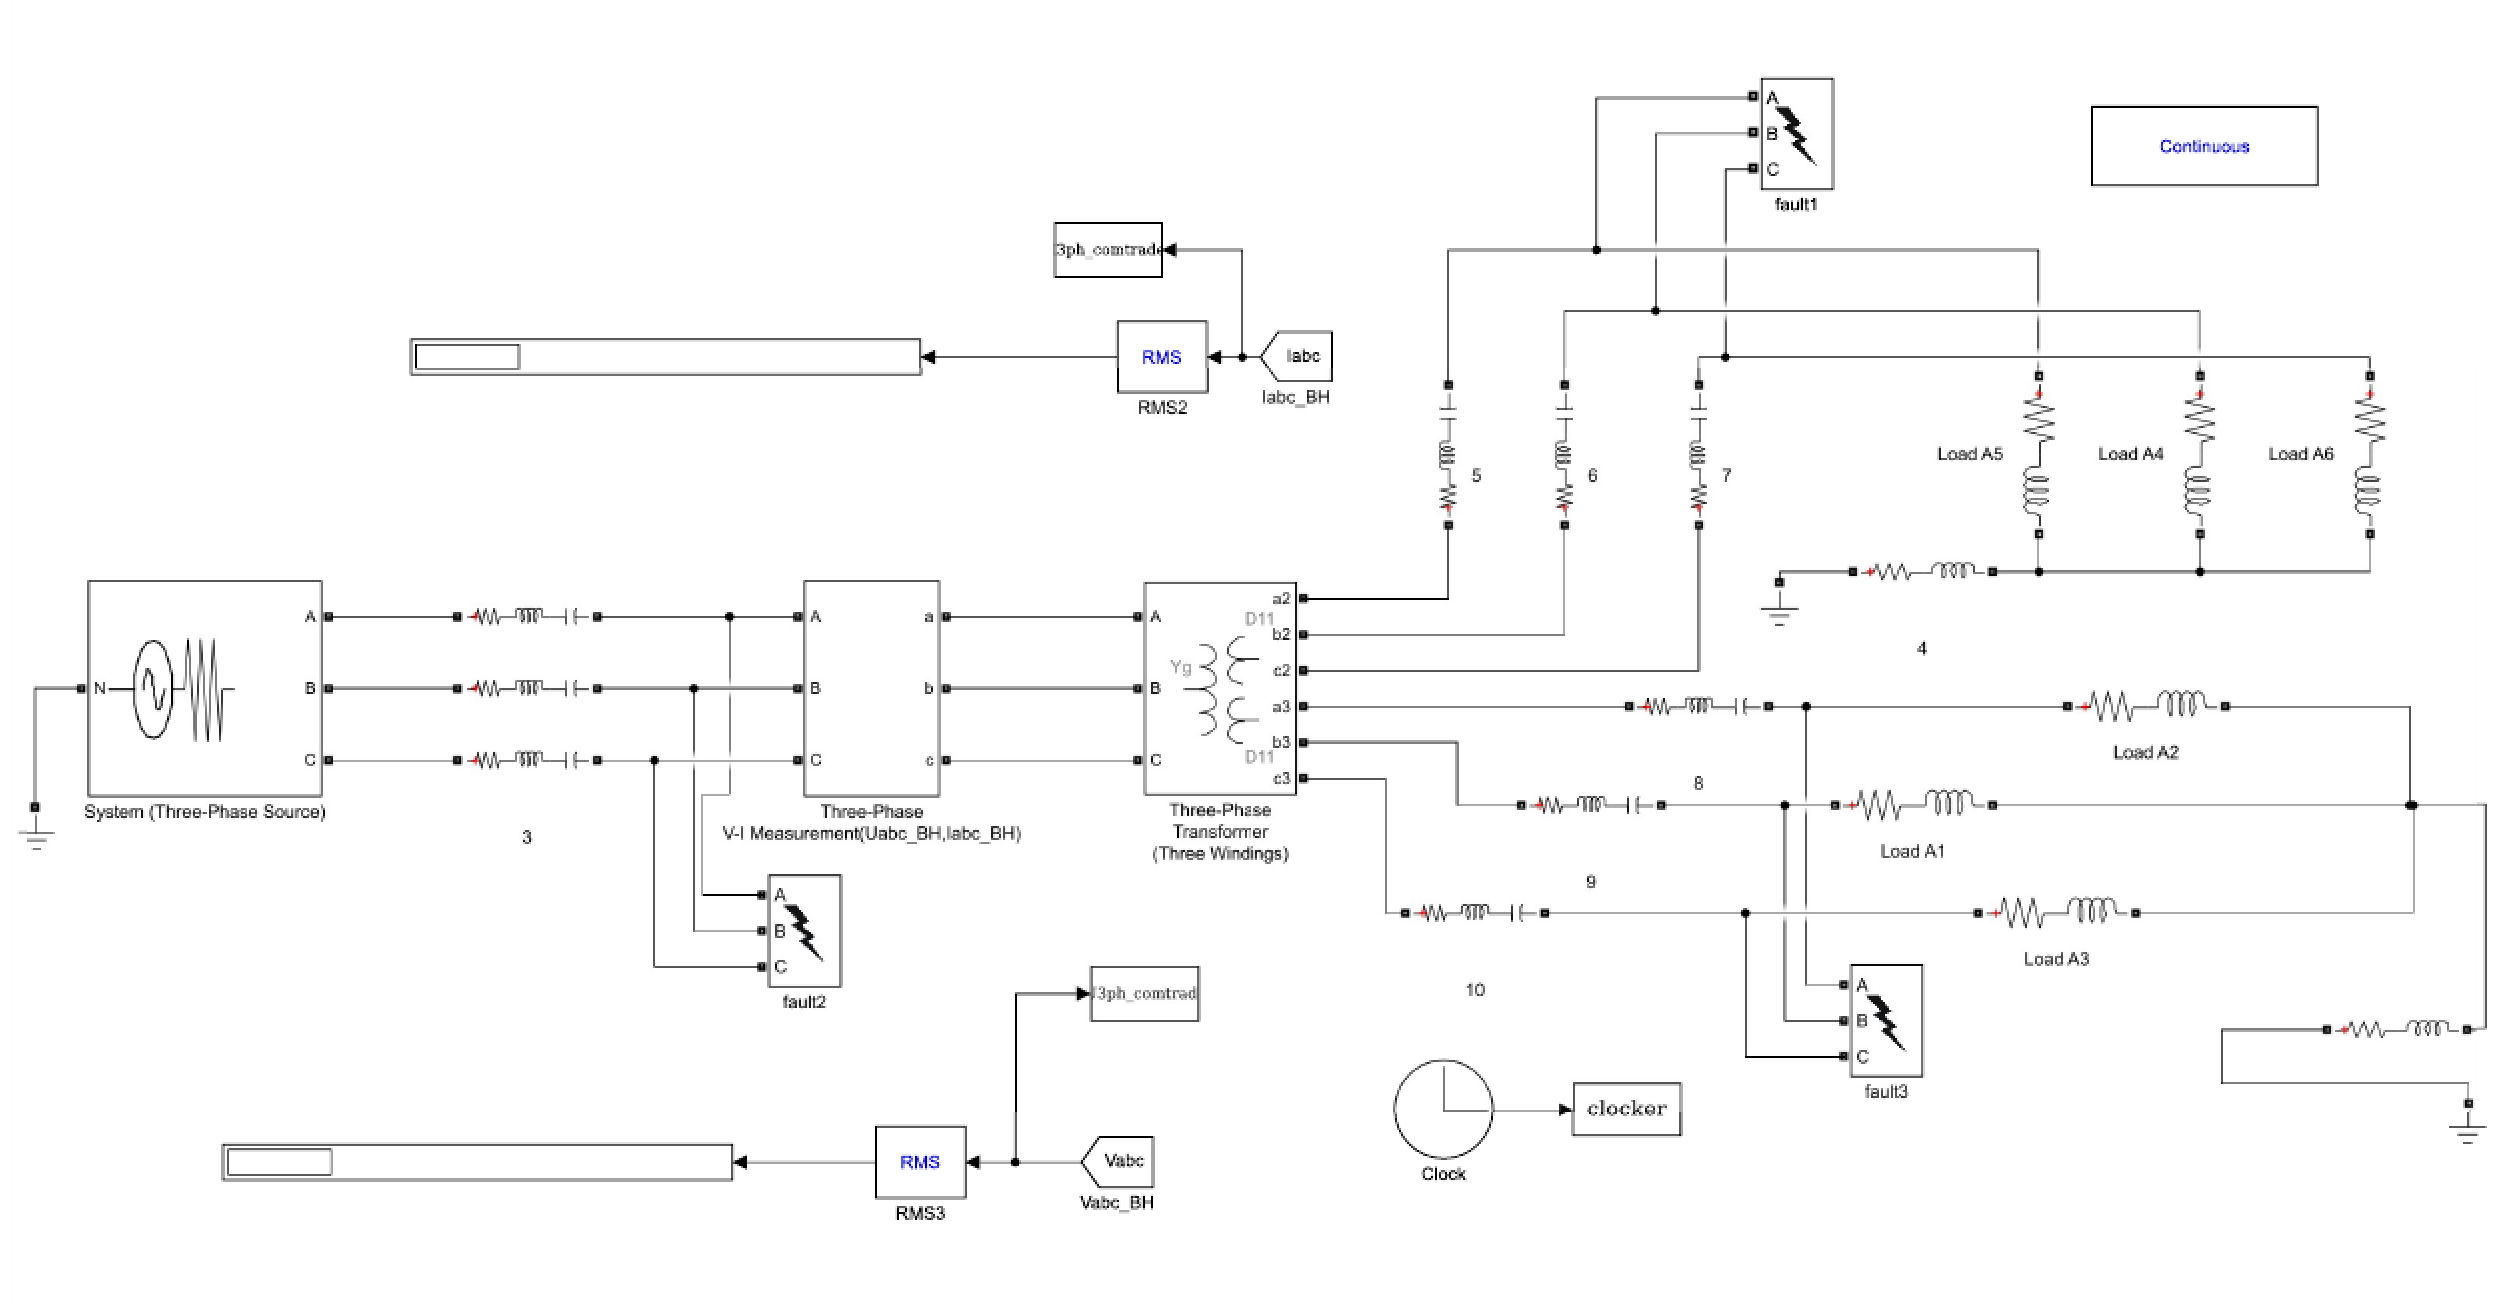

In [1]:
from IPython.display import Image
Image(filename = "pic.png", width = 1000, height = 600)

## 1. LIBRARIES IMPORT

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import random
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing import sequence
import seaborn as sns

C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Alexander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

## 2. DATA PATH LOADING

In [3]:
# Пути к каталогам с данными
data_dir = "C:\\Users\\Alexander\\PythonProjects\\AI_InPowerEl\\course_project\\data"

открываем прилагаемый к осциллограммам readme-файл с видами сгенерированных кз

In [4]:
with open(data_dir+'\\readme.txt', 'r') as file:
    regimes = file.read().split()
print(regimes)

['OnePhaseSC', 'TwoPhaseSC', 'ThreePhaseSC', 'Normal']


In [5]:
ph1 = glob.glob(os.path.join(data_dir, regimes[0]+'*.csv')) # file's name array

ph2 = glob.glob(os.path.join(data_dir, regimes[1]+'*.csv'))

ph3 = glob.glob(os.path.join(data_dir, regimes[2]+'*.csv'))

norm = glob.glob(os.path.join(data_dir, regimes[3]+'*.csv'))

In [6]:
print(len(ph1))
print(len(ph2))
print(len(ph3))
print(len(norm))

1141
1175
1084
999


 Визуализация одного датафрейма

In [7]:
data = pd.read_csv(ph1[0])
data

,time,Ia,Ib,Ic,Ua,Ub,Uc
0,0.000000e+00,-6.155922,-0.756653,8.682031,857.483492,-155846.346196,155783.018792
1,1.473094e-09,-6.155919,-0.756654,8.682032,857.566974,-155846.387710,155782.976699
2,8.838565e-09,-6.155905,-0.756659,8.682036,857.984385,-155846.595276,155782.766237
3,4.566592e-08,-6.155831,-0.756685,8.682061,860.071440,-155847.633094,155781.713913
4,2.298027e-07,-6.155466,-0.756813,8.682182,870.506714,-155852.821875,155776.451978
...,...,...,...,...,...,...,...
1495,1.336031e-01,-83.283956,2.325548,-5.583194,-712355.651247,147423.005622,16141.198836
1496,1.337031e-01,-83.424700,2.332435,-5.361507,-713856.617541,144116.146351,21776.728957
1497,1.338031e-01,-83.562296,2.337020,-5.134529,-715194.969628,140667.061834,27390.768016
1498,1.339031e-01,-83.696491,2.339299,-4.902485,-716368.595159,137079.155898,32977.775637


## 3. DATA PREPROCESSING

### 3.1. cutting 'timeseries' feature off the table

In [8]:
ph1_list = [pd.read_csv(x).drop(columns=['time'], axis=1) for x in ph1[:500]]

### visualization:

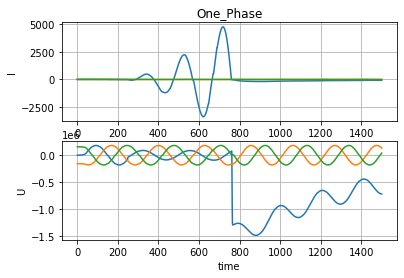

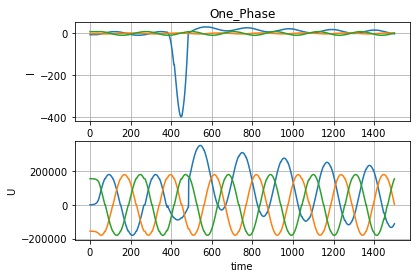

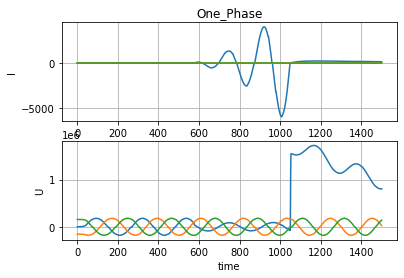

In [9]:
x = np.linspace(0,len(ph1_list[0]),len(ph1_list[0]))

for osc in range(3):
    osc1 = ph1_list[osc]
    
    
    plt.subplot(211)
    plt.plot(x, osc1.iloc[:,0:3])
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('I')
    plt.title('One_Phase')
    plt.subplot(212)
    plt.plot(x, osc1.iloc[:,3:])
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('U')
    plt.show()

для остальных видов кз

In [10]:
ph2_list = [pd.read_csv(x).drop(columns=['time'], axis=1) for x in ph2[:500]]
ph3_list=[pd.read_csv(x).drop(columns=['time'], axis=1) for x in ph3[:500]]
norm_list=[pd.read_csv(x).drop(columns=['time'], axis=1) for x in norm[:500]]

### 3.2. data normalization

составим функцию нормализации признаков силы тока

In [11]:
def normalize(data): #  array parameters normalization func
    mean = data[['Ia','Ib','Ic']].mean(axis=0)
    data[['Ia','Ib','Ic']] -= mean
    std = data[['Ia','Ib','Ic']].std(axis=0)
    data[['Ia','Ib','Ic']] /= std
    
    mean = data[['Ua','Ub','Uc']].mean(axis=0)
    data[['Ua','Ub','Uc']] -= mean
    std = data[['Ua','Ub','Uc']].std(axis=0)
    data[['Ua','Ub','Uc']] /= std
    
    return data

нормализируем

In [12]:
ph1_norm = [normalize(table) for table in ph1_list]
ph2_norm = [normalize(table) for table in ph2_list]
ph3_norm = [normalize(table) for table in ph3_list]
norm_norm = [normalize(table) for table in norm_list]

добавление к предобработанным данным столбца с меткой класса

In [13]:
ph1_norm = [pd.concat([i,pd.DataFrame({'regime':[0]})], axis=1) for i in ph1_norm]
ph2_norm = [pd.concat([i,pd.DataFrame({'regime':[1]})], axis=1) for i in ph2_norm]
ph3_norm = [pd.concat([i,pd.DataFrame({'regime':[2]})], axis=1) for i in ph3_norm]
norm_norm = [pd.concat([i,pd.DataFrame({'regime':[3]})], axis=1) for i in norm_norm]

создание второй выборки, исключающей признаки напряжения

In [14]:
i1_norm = [norm.drop(['Ua','Ub','Uc'],axis=1) for norm in ph1_norm]
i2_norm = [norm.drop(['Ua','Ub','Uc'],axis=1) for norm in ph2_norm]
i3_norm = [norm.drop(['Ua','Ub','Uc'],axis=1) for norm in ph3_norm]
in_norm = [norm.drop(['Ua','Ub','Uc'],axis=1) for norm in norm_norm]

нормализованная таблица признаков 'I'

In [15]:
in_norm[0]

,Ia,Ib,Ic,regime
0,-1.011333,-0.361674,1.315543,3.0
1,-1.011333,-0.361675,1.315543,NaN
2,-1.011330,-0.361678,1.315544,NaN
3,-1.011319,-0.361694,1.315548,NaN
4,-1.011260,-0.361773,1.315567,NaN
...,...,...,...,...
1495,0.936594,0.532563,-1.407676,NaN
1496,0.905969,0.571772,-1.415905,NaN
1497,0.874555,0.610559,-1.422973,NaN
1498,0.842380,0.648889,-1.428873,NaN


### 3.4 data preparing for train/test

разделим тензор данных на тензоры признаков и меток

In [16]:
def divide_df(norm_data): #  func divides x&y

    X = norm_data.drop(columns='regime', axis=1)
    y = norm_data['regime']
    return np.asarray(X), np.asarray(y)

In [17]:
ph1_x_y = [divide_df(table) for table in ph1_norm]
ph2_x_y = [divide_df(table) for table in ph2_norm]
ph3_x_y = [divide_df(table) for table in ph3_norm]
norm_x_y = [divide_df(table) for table in norm_norm]

i1_x_y = [divide_df(table) for table in i1_norm]
i2_x_y = [divide_df(table) for table in i2_norm]
i3_x_y = [divide_df(table) for table in i3_norm]
in_x_y = [divide_df(table) for table in in_norm]

создадим единый массив осциллограмм

In [18]:
dataset = []

for sett in ph1_x_y:
    dataset.append(sett)
for settt in ph2_x_y:
    dataset.append(settt)
for setttt in ph3_x_y:
    dataset.append(setttt)
for setttt in norm_x_y:
    dataset.append(setttt)    
    
i_dataset = []

for sett in i1_x_y:
    i_dataset.append(sett)
for settt in i2_x_y:
    i_dataset.append(settt)
for setttt in i3_x_y:
    i_dataset.append(setttt)
for setttt in in_x_y:
    i_dataset.append(setttt)       

перетасовка списка

In [19]:
random.shuffle(dataset)
random.shuffle(i_dataset)

разделение списка на тренируемую и обучаемую выборки

In [20]:
train_data = dataset[:int(len(dataset)*0.6)]
val_data = dataset[int(len(dataset)*0.6):int(len(dataset)*0.8)]
test_data = dataset[int(len(dataset)*0.8):]

i_train_data = i_dataset[:int(len(i_dataset)*0.6)]
i_val_data = i_dataset[int(len(i_dataset)*0.6):int(len(i_dataset)*0.8)]
i_test_data = i_dataset[int(len(i_dataset)*0.8):]

составление из каждого объекта выборки отдельной выборки признаков и ответов

In [21]:
def convert_targets(train, val, test): # just weird func 
    y_train  = [y[1] for y in train]
    y_val  = [y[1] for y in val]

    y_test  = [y[1] for y in test]
    return  np.asarray([[i[0]] for i in y_train]),np.asarray([[i[0]] for i in y_val]), np.asarray([[i[0]] for i in y_test])

In [22]:
X_train = np.asarray([X[0] for X in train_data])
iX_train = np.asarray([X[0] for X in i_train_data])

X_val = np.asarray([X[0] for X in val_data])
iX_val = np.asarray([X[0] for X in i_val_data])

X_test = np.asarray([X[0] for X in test_data])
iX_test = np.asarray([X[0] for X in i_test_data])

y_train, y_val, y_test = convert_targets(train_data,val_data, test_data)
iy_train, iy_val, iy_test = convert_targets(i_train_data, i_val_data, i_test_data)

наблюдаемый срез получившихся списков

In [23]:
X_train.shape

(1200, 1500, 6)

In [24]:
y_train.shape

(1200, 1)

In [25]:
X_test.shape

(400, 1500, 6)

In [26]:
iy_test.shape

(400, 1)

перевод списка меток в бинарную матрицу

In [28]:
y_train = to_categorical(y_train, 4)
y_val = to_categorical(y_val, 4)
y_test = to_categorical(y_test, 4)

iy_val = to_categorical(iy_val, 4)
iy_train = to_categorical(iy_train, 4)
iy_test = to_categorical(iy_test, 4)

## 4. TRAINING/TESTING

### 4.1 training

составим функцию модели рекуррентной сети

In [48]:
# def design_model(x_data, y_data, x_val, y_val, verbose= 1, epochs=15, batch_size =64,
#                  num_n = 50, l_num=1, arc='LSTM', loss = 'categorical_crossentropy', optimizer='adam', metrics=['Precision','Recall','AUC']): 
#     # recurrent model func
        
#     n_timesteps, n_features,  n_outputs = x_data.shape[1], x_data.shape[2], y_data.shape[1]
#     model = Sequential()
    
#     RGU = {
#     '1': model.add(RGU(num_n, input_shape=(n_timesteps,n_features))),
#     '2': model.add(RGU(num_n, input_shape=(n_timesteps,n_features))),
# }
    
#     LSTM = {
#     '1': model.add(LSTM(num_n, input_shape=(n_timesteps,n_features))),
#     '2': model.add(LSTM(num_n, input_shape=(n_timesteps,n_features))),
# }
#     Simple_RNN = {
#     '1': model.add(Simple_RNN(num_n, input_shape=(n_timesteps,n_features))),
#     '2': model.add(Simple_RNN(num_n, input_shape=(n_timesteps,n_features))),
# }
    
    
#     arcc = {
#     'LSTM': (try:
#                 ch = LSTM[l_num]
#             except KeyError as e:
#                 raise ValueError('Неподдерживаемое количество слоев')),
#     'GRU': 
#         try:
#             ch = GRU[l_num]
#         except KeyError as e:
#             raise ValueError('Неподдерживаемое количество слоев'),
#     'Simple_RNN': 
#         try:
#             ch = Simple_RNN[l_num]
#         except KeyError as e:
#             raise ValueError('Неподдерживаемое количество слоев'),
# }
    
#     try:
#         ch = arcc[arc]
# except KeyError as e:
#     # можно также присвоить значение по умолчанию вместо бросания исключения
#     raise ValueError('Неподдерживаемая архитектура')

    
# #     model.add(LSTM(num_n, input_shape=(n_timesteps,n_features)))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_n, activation='relu'))
#     model.add(Dense(n_outputs, activation='softmax'))
#     model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#     history = model.fit(x_data, y_data, epochs=epochs, validation_data=(x_val, y_val), batch_size=batch_size, verbose=verbose)
    
#     return model, history

In [59]:
def design_model(x_data, y_data, x_val, y_val, verbose= 1, epochs=15, batch_size =64,
                 num_n = 50, loss = 'categorical_crossentropy', optimizer='adam', metrics=['Precision','Recall','AUC']): 
    # recurrent model func
    n_timesteps, n_features,  n_outputs = x_data.shape[1], x_data.shape[2], y_data.shape[1]
    model = Sequential()
    model.add(LSTM(num_n, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(num_n, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(x_data, y_data, epochs=epochs, validation_data=(x_val, y_val), batch_size=batch_size, verbose=verbose)
    
    return model, history

создадим и обучим модель на основе выборки токов

In [30]:
model, i_history = design_model(iX_train,iy_train, iX_val, iy_val)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1200 samples, validate on 400 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
1200/1200 [==============================] - 48s 40ms/sample - loss: 1.3459 - precision: 0.8889 - recall: 0.0067 - auc: 0.5768 - val_loss: 1.2484 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7121
Epoch 2/15
1200/1200 [==============================] - 42s 35ms/sample - loss: 1.2159 - precision: 0.7516 - recall: 0.2017 - auc: 0.7045 - val_loss: 1.1007 - val_precision: 0.8049 - val_recall: 0.2475 - val_auc: 0.8171
Epoch 3/15
1200/1200 [==============================] - 28s 24ms/sample - loss: 1.0453 - precision: 0.7587 - recall: 0.2358 - auc: 0.8371 - val_loss: 0.8575 - val_precision: 0.9173 - val_recall: 0.3050 - val_auc: 0.9197
Epoch 4/15
1200/1200 [==============================] - 28s 24ms/sample -

распишем функции, полезные для преобразования прогнозируемых ответов в исходное состояние 

### 4.2 testing

In [ ]:
def confus_matrix(pred, true):

    cm_df = pd.DataFrame(data = confusion_matrix(pred, true), columns = ['OnePhTrue','TwoPhTrue','ThreePhTrue','Normal'],
                         index = ['OnePhPred','TwoPhPred','ThreePhPred','Normal'])
    
    f, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(cm_df, annot=True, fmt='d')
    return ax

In [54]:
def metrics_plot( h,epochs=15):
    met = h.params['metrics']
    f1_score_list_train = [2*i*j/(i+j) for i,j in zip(h.history[met[1]],h.history[met[2]])]
    f1_score_list_test = [2*i*j/(i+j) for i,j in zip(h.history[met[5]],h.history[met[6]])]
    auc_train = [i for i in h.history[met[3]]]
    auc_test = [i for i in h.history[met[7]]]
    loses_train = [i for i in h.history[met[0]]]
    loses_test = [i for i in h.history[met[4]]]

    
    x = np.linspace(0,1,epochs)
    plt.figure(figsize=(10,6))
  
    plt.subplot(311)
    plt.plot(x, f1_score_list_train)
    plt.plot(x, f1_score_list_test) 
    plt.legend(['train','test'], loc = 'upper left')

    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('f1_score')
    plt.title('metrics')
    plt.subplot(312)
    plt.plot(x, auc_train)
    plt.plot(x, auc_test)
    plt.legend(['train','test'], loc = 'upper left')

    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('auc')
    plt.subplot(313)
    plt.plot(x, loses_train)
    plt.plot(x, loses_test) 
    plt.legend(['train','test'], loc = 'lower left')

    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.show()

протестируем модель на тестовой выборке

In [33]:
pred = model.predict(iX_test, batch_size=64, verbose=1)

400/400 [==============================] - 2s 6ms/sample


In [34]:
ans_pred = np.argmax(pred, axis=-1)
ans_true  =np.argmax(iy_test, axis=-1)# 2 means 3 (in fact, you should use "-1")

<AxesSubplot:>

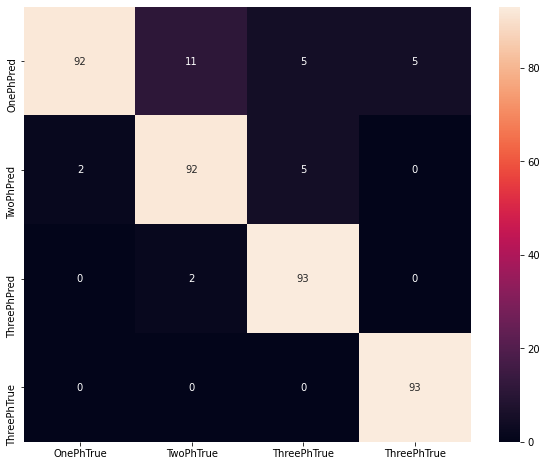

In [35]:
confus_matrix(ans_true[:len(ans_true)], ans_pred)

покажем качество прогнозирования на матрице ошибок и тенденции f-скоринга

C:\Users\Alexander\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


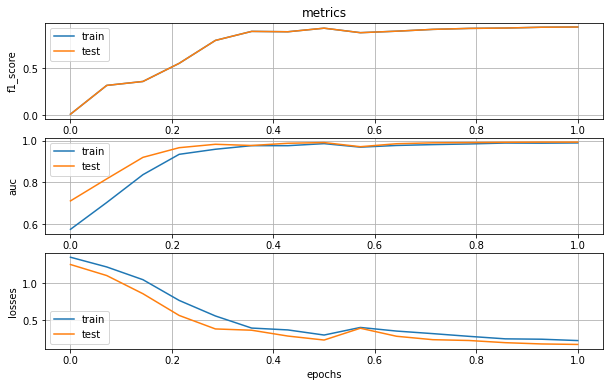

In [36]:
metrics_plot(i_history)

как можно убедиться, модель показала убедительные результаты в прогнозировании

### 4.3 bonuse

составим модель на основе полной выборки признаков токов и напряжений

In [37]:
model, history2  = design_model(X_train,y_train, X_val,y_val, epochs=15)

Train on 1200 samples, validate on 400 samples
Epoch 1/15
1200/1200 [==============================] - 65s 54ms/sample - loss: 1.3417 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2: 0.6023 - val_loss: 1.2462 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.7433
Epoch 2/15
1200/1200 [==============================] - 61s 51ms/sample - loss: 1.1867 - precision_2: 0.8102 - recall_2: 0.0925 - auc_2: 0.7621 - val_loss: 1.0084 - val_precision_2: 0.8188 - val_recall_2: 0.2825 - val_auc_2: 0.8506
Epoch 3/15
1200/1200 [==============================] - 58s 48ms/sample - loss: 0.9488 - precision_2: 0.7281 - recall_2: 0.3458 - auc_2: 0.8478 - val_loss: 0.7441 - val_precision_2: 0.8430 - val_recall_2: 0.5100 - val_auc_2: 0.9232
Epoch 4/15
1200/1200 [==============================] - 58s 48ms/sample - loss: 0.6978 - precision_2: 0.8188 - recall_2: 0.5725 - auc_2: 0.9240 - val_loss: 0.4948 - val_precision_2: 0.9042 - val_recall_2: 0.7550 - val_auc_2: 0.9710
Epoch 5/1

In [39]:
ans_pred = np.argmax(pred, axis=-1)
ans_true  =np.argmax(iy_test, axis=-1)# 2 means 3 (in fact, you should use "-1")

<AxesSubplot:>

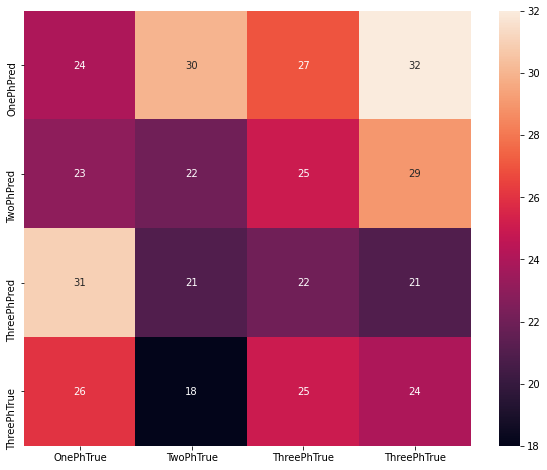

In [40]:
confus_matrix(ans_true[:len(ans_true)], ans_pred)

C:\Users\Alexander\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alexander\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


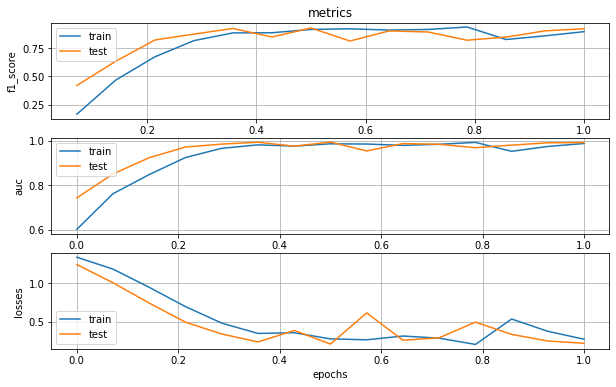

In [43]:
metrics_plot(history2, epochs=15)

посмотрим, когда модель приходит к переобучению. Обучим её на epochs=50

In [50]:
model, history2  = design_model(X_train,y_train, X_val,y_val, epochs=50)

Train on 1200 samples, validate on 400 samples
Epoch 1/50
1200/1200 [==============================] - 70s 58ms/sample - loss: 1.3562 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5772 - val_loss: 1.2575 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.7666
Epoch 2/50
1200/1200 [==============================] - 58s 48ms/sample - loss: 1.1922 - precision_4: 0.8817 - recall_4: 0.0683 - auc_4: 0.7660 - val_loss: 0.9936 - val_precision_4: 0.8409 - val_recall_4: 0.2775 - val_auc_4: 0.8724
Epoch 3/50
1200/1200 [==============================] - 52s 43ms/sample - loss: 0.9147 - precision_4: 0.7717 - recall_4: 0.4000 - auc_4: 0.8666 - val_loss: 0.6857 - val_precision_4: 0.9267 - val_recall_4: 0.6325 - val_auc_4: 0.9518
Epoch 4/50
1200/1200 [==============================] - 55s 46ms/sample - loss: 0.6606 - precision_4: 0.8337 - recall_4: 0.6058 - auc_4: 0.9385 - val_loss: 0.4789 - val_precision_4: 0.9085 - val_recall_4: 0.7450 - val_auc_4: 0.9714
Epoch 5/5

Epoch 36/50
1200/1200 [==============================] - 49s 41ms/sample - loss: 0.1202 - precision_4: 0.9704 - recall_4: 0.9567 - auc_4: 0.9956 - val_loss: 0.1463 - val_precision_4: 0.9492 - val_recall_4: 0.9350 - val_auc_4: 0.9951
Epoch 37/50
1200/1200 [==============================] - 49s 41ms/sample - loss: 0.1206 - precision_4: 0.9755 - recall_4: 0.9608 - auc_4: 0.9951 - val_loss: 0.1443 - val_precision_4: 0.9541 - val_recall_4: 0.9350 - val_auc_4: 0.9952
Epoch 38/50
1200/1200 [==============================] - 50s 42ms/sample - loss: 0.1133 - precision_4: 0.9738 - recall_4: 0.9600 - auc_4: 0.9963 - val_loss: 0.1579 - val_precision_4: 0.9518 - val_recall_4: 0.9375 - val_auc_4: 0.9932
Epoch 39/50
1200/1200 [==============================] - 49s 41ms/sample - loss: 0.1122 - precision_4: 0.9747 - recall_4: 0.9650 - auc_4: 0.9953 - val_loss: 0.1586 - val_precision_4: 0.9470 - val_recall_4: 0.9375 - val_auc_4: 0.9931
Epoch 40/50
1200/1200 [==============================] - 49s 41ms/sa

In [51]:
ns_pred = np.argmax(pred, axis=-1)
ans_true  =np.argmax(iy_test, axis=-1)# 2 means 3 (in fact, you should use "-1")

C:\Users\Alexander\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alexander\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


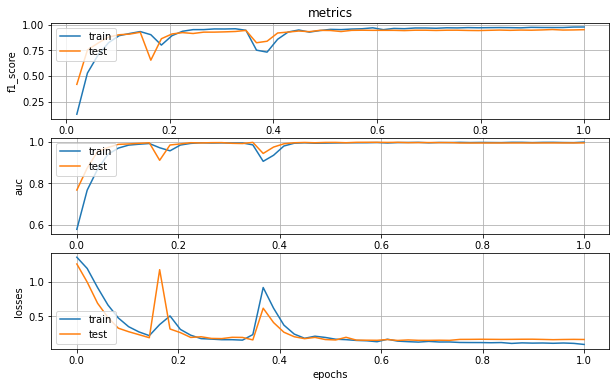

In [55]:
metrics_plot(history2, epochs=50)

<AxesSubplot:>

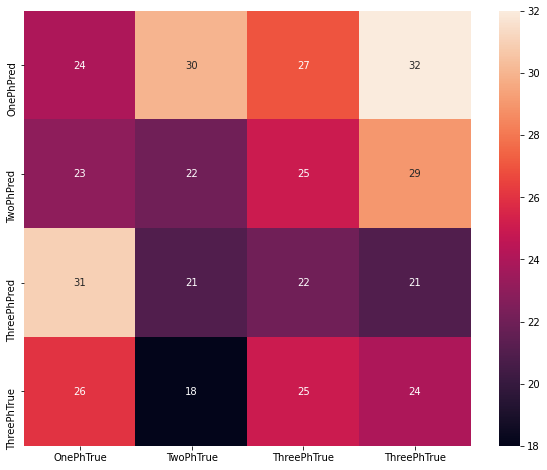

In [57]:
confus_matrix(ans_true[:len(ans_pred)], ans_pred)

In [ ]:
model, history2  = design_model(X_train,y_train, X_val,y_val, epochs=15, num_n=100)

Train on 1200 samples, validate on 400 samples
Epoch 1/15
1200/1200 [==============================] - 294s 245ms/sample - loss: 1.2139 - precision_6: 0.7278 - recall_6: 0.1092 - auc_6: 0.7198 - val_loss: 0.9637 - val_precision_6: 0.7523 - val_recall_6: 0.4025 - val_auc_6: 0.8344
Epoch 2/15
1200/1200 [==============================] - 313s 261ms/sample - loss: 0.8543 - precision_6: 0.7318 - recall_6: 0.4525 - auc_6: 0.8709 - val_loss: 0.6431 - val_precision_6: 0.7922 - val_recall_6: 0.6575 - val_auc_6: 0.9280
Epoch 3/15
1200/1200 [==============================] - 290s 242ms/sample - loss: 0.5114 - precision_6: 0.8626 - recall_6: 0.7483 - auc_6: 0.9581 - val_loss: 0.3328 - val_precision_6: 0.9290 - val_recall_6: 0.8175 - val_auc_6: 0.9845
Epoch 4/15
1200/1200 [==============================] - 309s 258ms/sample - loss: 0.4150 - precision_6: 0.8867 - recall_6: 0.7958 - auc_6: 0.9697 - val_loss: 0.3012 - val_precision_6: 0.9539 - val_recall_6: 0.8275 - val_auc_6: 0.9855
Epoch 5/15
 256/1

In [ ]:
ns_pred = np.argmax(pred, axis=-1)
ans_true  =np.argmax(iy_test, axis=-1)# 2 means 3 (in fact, you should use "-1")

In [ ]:
metrics_plot(history2, epochs=15)

# 5. REVIEW

Данная модель показала себя в достаточной степени эффективно: как в случае с обучением только по токам КЗ, так и по всем снятым параметрам режима рекуррентная сеть обучилась и справилась с прогнозированием на тестировочной выборке успешно.

Ссылка на полную версию проекта